# Training mô hình trích xuất tên thuốc


### Phần 1. Đồ thị hoá tài liệu

##### Bước 1: Tiền xử lý tài liệu

In [22]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import math
import itertools

# for making adjacency matrix
import networkx as nx

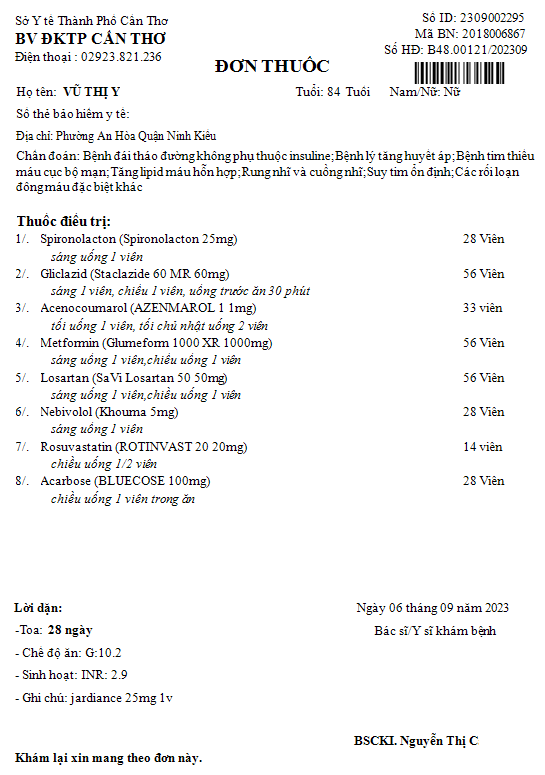

In [23]:
from PIL import Image

image = Image.open("../img/001.png")
image

In [24]:
image = cv2.imread("../img/001.png")
filename = "001.csv"

# Preprocess data

filepath = "../data/box/" + filename
df = pd.read_csv(filepath, header=None, sep="\t")
df = df[0].str.split(",", expand=True)
temp = df.copy()
temp[temp.columns] = temp.apply(lambda x: x.str.strip())
temp.fillna("", inplace=True)
temp[8] = temp[8].str.cat(temp.iloc[:, 9:-1], sep=", ")
temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
temp = temp.loc[:, :8]
temp.drop([2, 3, 6, 7], axis=1, inplace=True)
temp.columns = ["xmin", "ymin", "xmax", "ymax", "Object"]
temp[["xmin", "ymin", "xmax", "ymax"]] = temp[["xmin", "ymin", "xmax", "ymax"]].apply(
    pd.to_numeric
)

df = temp
print(df)

    xmin  ymin  xmax  ymax                                             Object
0    420    10   525    24                                  Số ID: 2309002295
1     13    13   169    26                          Sở Y tê Thành Phố Cần Thơ
2    413    26   525    40                                  Mã BN: 2018006867
3     13    29   166    45                                    BV ĐKTP CẦN THƠ
4    382    41   528    56                            Số HĐ: B48.00121.202309
5     13    49   162    64                          Điện thoại: 02923 821.236
6    213    54   332    74                                          ĐƠN THUỐC
7     14    82   121    98                                   Họ tên: vũ thị y
8    293    82   461    97                               Tuổi: 84 Tuổi Nam Nữ
9     14   106   130   122                               Số thê bảo hiếm y tế
10    14   129   217   144              Địa chỉ: Phường An Hòa Quận Ninh Kiêu
11    14   148   534   164  "Thần đoán: Bệnh đãi thao dường khôn

In [25]:
image_height, image_width = image.shape[0], image.shape[1]

In [26]:

print(f'Type of df (global variable): {type(df)}')

Type of df (global variable): <class 'pandas.core.frame.DataFrame'>


In [27]:
# sort df by 'top' coordinate.
def line_formation(boundingbox_df):
    """
    args:
        df with words and cordinates (xmin,xmax,ymin,ymax)
    returns:
        df with words arranged in orientation top to bottom and left to right

    """
    assert (
        type(df) == pd.DataFrame
    ), f"object_map should be of type \
        {pd.DataFrame}. Received {type(boundingbox_df)}"
    assert (
        type(image) == np.ndarray
    ), f"image should be of type {np.ndarray} \
        . Received {type(image)}"

    assert "xmin" in boundingbox_df.columns, '"xmin" not in object map'
    assert "xmax" in boundingbox_df.columns, '"xmax" not in object map'
    assert "ymin" in boundingbox_df.columns, '"ymin" not in object map'
    assert "ymax" in boundingbox_df.columns, '"ymax" not in object map'
    assert "Object" in boundingbox_df.columns, '"Object" column not in object map'
    # remove empty spaces both in front and behind
    df.columns = df.columns.str.strip()

    # further cleaning
    df.dropna(inplace=True)
    # sort from top to bottom
    df.sort_values(by=["ymin"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right
    df["ymax"] = df["ymax"].apply(lambda x: x - 1)

    """

    _______________y axis__________
    |
    |                       top    
    x axis               ___________________
    |              left | bounding box      |  right
    |                   |___________________|           
    |                       bottom 
    |
    |


    iterate through the rows twice to compare them.
    remember that the axes are inverted.
    """
    master = []
    for idx, row in df.iterrows():
        # flatten the nested list
        flat_master = list(itertools.chain(*master))
        # print(flat_master)
        # check to see if idx is in flat_master
        if idx not in flat_master:
            top_a = row["ymin"]
            bottom_a = row["ymax"]
            # top, bottom, right, left
            # coordinates = (row['ymin'],row['ymax'],row['xmin'],row['xmax'])
            # print(coordinates)

            # line will atleast have the word in it
            line = [idx]
            # line1=[row['Object']]

            for idx_2, row_2 in df.iterrows():
                # check to see if idx_2 is in flat_master removes ambiguity
                # picks higher cordinate one.
                if idx_2 not in flat_master:
                    # if not the same words
                    if not idx == idx_2:
                        top_b = row_2["ymin"]
                        bottom_b = row_2["ymax"]
                        if (top_a <= bottom_b) and (bottom_a >= top_b):
                            line.append(idx_2)
                            # print(line)
            master.append(line)

    df2 = pd.DataFrame(
        {"words_indices": master, "line_number": [x for x in range(1, len(master) + 1)]}
    )

    # explode the list columns eg : [1,2,3]
    df2 = (
        df2.set_index("line_number")
        .words_indices.apply(pd.Series)
        .stack()
        .reset_index(level=0)
        .rename(columns={0: "words_indices"})
    )

    df2["words_indices"] = df2["words_indices"].astype("int")

    # put the line numbers back to the list
    final = df.merge(df2, left_index=True, right_on="words_indices")

    final.drop("words_indices", axis=1, inplace=True)

    """
    3) Sort words in each line based on Left coordinate
    """
    final2 = (
        final.sort_values(by=["line_number", "xmin"], ascending=True)
        .groupby("line_number")
        .head(len(final))
        .reset_index(drop=True)
    )

    return final2


line_formation(df)

,xmin,ymin,xmax,ymax,Object,line_number
0,13,13,169,25,Sở Y tê Thành Phố Cần Thơ,1
1,420,10,525,23,Số ID: 2309002295,1
2,13,29,166,44,BV ĐKTP CẦN THƠ,2
3,413,26,525,39,Mã BN: 2018006867,2
4,13,49,162,63,Điện thoại: 02923 821.236,3
5,213,54,332,73,ĐƠN THUỐC,3
6,382,41,528,55,Số HĐ: B48.00121.202309,3
7,14,82,121,97,Họ tên: vũ thị y,4
8,293,82,461,96,Tuổi: 84 Tuổi Nam Nữ,4
9,14,106,130,121,Số thê bảo hiếm y tế,5


In [28]:
df = line_formation(df)


def grapher(df, export_graph=False):
    # horizontal edges formation
    # print(df)
    df.reset_index(inplace=True)

    grouped = df.groupby("line_number")

    # for undirected graph construction
    horizontal_connections = {}

    # left
    left_connections = {}

    # right
    right_connections = {}

    for _, group in grouped:
        a = group["index"].tolist()
        b = group["index"].tolist()
        # b.reverse()
        # a = 0,1,2
        # 2
        horizontal_connection = {a[i]: a[i + 1] for i in range(len(a) - 1)}

        # storing directional connections
        right_dict_temp = {a[i]: {"right": a[i + 1]} for i in range(len(a) - 1)}
        left_dict_temp = {b[i + 1]: {"left": b[i]} for i in range(len(b) - 1)}

        # add the indices in the dataframes
        for i in range(len(a) - 1):
            df.loc[df["index"] == a[i], "right"] = int(a[i + 1])
            df.loc[df["index"] == a[i + 1], "left"] = int(a[i])

        left_connections.update(right_dict_temp)
        right_connections.update(left_dict_temp)
        horizontal_connections.update(horizontal_connection)

    dic1, dic2 = left_connections, right_connections

    # verticle connections formation

    bottom_connections = {}
    top_connections = {}

    for idx, row in df.iterrows():
        if idx not in bottom_connections.keys():
            right_a = row["xmax"]
            left_a = row["xmin"]

            for idx_2, row_2 in df.iterrows():
                # check for higher idx values

                if idx_2 not in bottom_connections.values() and idx < idx_2:
                    # if idx_2 not in bottom_connections.values() and (idx != idx_2):
                    right_b = row_2["xmax"]
                    left_b = row_2["xmin"]
                    if (left_b <= right_a) and (right_b >= left_a):
                        bottom_connections[idx] = idx_2

                        top_connections[idx_2] = idx

                        # add it to the dataframe
                        df.loc[df["index"] == idx, "bottom"] = idx_2
                        df.loc[df["index"] == idx_2, "top"] = idx

                        # print(bottom_connections)

                        # once the condition is met, break the loop to reduce redundant time complexity
                        break

                        # below = True

    # print(df)

    # print('bottom connections:', bottom_connections)
    # # print(top_connections)
    # print('horizontal connections:', horizontal_connections)

    # combining both
    result = {}
    dic1 = horizontal_connections
    dic2 = bottom_connections

    for key in dic1.keys() | dic2.keys():
        if key in dic1:
            result.setdefault(key, []).append(dic1[key])
        if key in dic2:
            result.setdefault(key, []).append(dic2[key])
    # print(result)

    G = nx.from_dict_of_lists(result)

    if export_graph:
        file, _ = os.path.splitext(filename)
        plot_path = "../Graph/" + file + "plain_graph" ".jpg"
        if not os.path.exists(plot_path):   
            layout = nx.kamada_kawai_layout(G)
            nx.draw(G, layout, with_labels=True)
            plt.savefig(plot_path, format="PNG")
            plt.title(f"Graph form of {file}")
            plt.show()

    return result, G, df


# features calculation

dict_graph, graph, processed_df = grapher(df, export_graph=True)

In [29]:
dict_graph

{0: [1, 2],
 1: [3],
 2: [3, 4],
 3: [6],
 4: [5, 7],
 5: [6, 8],
 6: [11],
 7: [8, 9],
 8: [12],
 9: [10],
 10: [13],
 11: [12, 14],
 12: [15],
 13: [17],
 14: [18],
 15: [16, 20],
 16: [19],
 17: [21],
 18: [19, 23],
 19: [22],
 20: [24],
 21: [22, 26],
 22: [25],
 23: [27],
 24: [25, 29],
 25: [28],
 26: [30],
 27: [28, 32],
 28: [31],
 29: [33],
 30: [31, 35],
 31: [34],
 32: [36],
 33: [34, 38],
 34: [37],
 35: [36, 39],
 36: [41],
 37: [40],
 38: [43],
 39: [40, 44],
 40: [42],
 41: [42, 45],
 42: [46],
 43: [47]}

In [30]:
graph

In [31]:
processed_df

,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,top
0,0,13,13,169,24,Sở Y tê Thành Phố Cần Thơ,1,1.0,NaN,2.0,NaN
1,1,420,10,525,22,Số ID: 2309002295,1,NaN,0.0,3.0,NaN
2,2,13,29,166,43,BV ĐKTP CẦN THƠ,2,3.0,NaN,4.0,0.0
3,3,413,26,525,38,Mã BN: 2018006867,2,NaN,2.0,6.0,1.0
4,4,13,49,162,62,Điện thoại: 02923 821.236,3,5.0,NaN,7.0,2.0
5,5,213,54,332,72,ĐƠN THUỐC,3,6.0,4.0,8.0,NaN
6,6,382,41,528,54,Số HĐ: B48.00121.202309,3,NaN,5.0,11.0,3.0
7,7,14,82,121,96,Họ tên: vũ thị y,4,8.0,NaN,9.0,4.0
8,8,293,82,461,95,Tuổi: 84 Tuổi Nam Nữ,4,NaN,7.0,12.0,5.0
9,9,14,106,130,120,Số thê bảo hiếm y tế,5,NaN,NaN,10.0,7.0


In [32]:
def relative_distance(df):
    # RDL and RDT are negative while RDR and RDB are positive
    plot_df = df.copy()

    for index in df["index"].to_list():
        right_index = df.loc[df["index"] == index, "right"].values[0]
        left_index = df.loc[df["index"] == index, "left"].values[0]
        bottom_index = df.loc[df["index"] == index, "bottom"].values[0]
        top_index = df.loc[df["index"] == index, "top"].values[0]

        # rd_r = (right_word_xmin - left_word_xmax)/image_width

        # check if it is nan value
        if np.isnan(right_index) == False:
            right_word_left = df.loc[df["index"] == right_index, "xmin"].values[0]
            source_word_right = df.loc[df["index"] == index, "xmax"].values[0]

            df.loc[df["index"] == index, "rd_r"] = (
                right_word_left - source_word_right
            ) / image_width

            """
            for plotting purposes
            getting the mid point of the values to draw the lines for the graph
            mid points of source and destination for the bounding boxes
            """

            right_word_x_max = df.loc[df["index"] == right_index, "xmax"].values[0]
            right_word_y_max = df.loc[df["index"] == right_index, "ymax"].values[0]
            right_word_y_min = df.loc[df["index"] == right_index, "ymin"].values[0]

            # source_word_x_min = df.loc[df['index'] == index, 'xmin'].values[0]

            # source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]
            # source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]

            plot_df.loc[df["index"] == index, "destination_x_hori"] = (
                right_word_x_max + right_word_left
            ) / 2
            plot_df.loc[df["index"] == index, "destination_y_hori"] = (
                right_word_y_max + right_word_y_min
            ) / 2
            # plot_df.loc[df['index'] == index, 'source_x_hori'] = (source_word_right - source_word_x_min)/2
            # plot_df.loc[df['index'] == index, 'source_y_hori'] = (source_word_right - source_word_min)/2

        if np.isnan(left_index) == False:
            left_word_right = df.loc[df["index"] == left_index, "xmax"].values[0]
            source_word_left = df.loc[df["index"] == index, "xmin"].values[0]

            df.loc[df["index"] == index, "rd_l"] = (
                left_word_right - source_word_left
            ) / image_width

        if np.isnan(bottom_index) == False:
            bottom_word_top = df.loc[df["index"] == bottom_index, "ymin"].values[0]
            source_word_bottom = df.loc[df["index"] == index, "ymax"].values[0]

            df.loc[df["index"] == index, "rd_b"] = (
                bottom_word_top - source_word_bottom
            ) / image_height

            # for plotting purposes
            bottom_word_top_max = df.loc[df["index"] == bottom_index, "ymax"].values[0]
            # source_word_min = df.loc[df['index'] == index, 'ymin'].values[0]
            bottom_word_x_max = df.loc[df["index"] == bottom_index, "xmax"].values[0]
            bottom_word_x_min = df.loc[df["index"] == bottom_index, "xmin"].values[0]

            plot_df.loc[df["index"] == index, "destination_y_vert"] = (
                bottom_word_top_max + bottom_word_top
            ) / 2
            plot_df.loc[df["index"] == index, "destination_x_vert"] = (
                bottom_word_x_max + bottom_word_x_min
            ) / 2
            # plot_df.loc[df['index'] == index, 'source_y_vert'] = (source_word_bottom - source_word_min)/2

        if np.isnan(top_index) == False:
            top_word_bottom = df.loc[df["index"] == top_index, "ymax"].values[0]
            source_word_top = df.loc[df["index"] == index, "ymin"].values[0]

            df.loc[df["index"] == index, "rd_t"] = (
                top_word_bottom - source_word_top
            ) / image_height

    # replace all tne NaN values with '0' meaning there is nothing in that direction
    df[["rd_r", "rd_b", "rd_l", "rd_t"]] = df[["rd_r", "rd_b", "rd_l", "rd_t"]].fillna(
        0
    )

    plot_df["rd_r"] = df["rd_r"]
    plot_df["rd_b"] = df["rd_b"]

    return df, plot_df

In [33]:
df, plot_df = relative_distance(processed_df)
print(plot_df)

    index  xmin  ymin  xmax  ymax  \
0       0    13    13   169    24   
1       1   420    10   525    22   
2       2    13    29   166    43   
3       3   413    26   525    38   
4       4    13    49   162    62   
5       5   213    54   332    72   
6       6   382    41   528    54   
7       7    14    82   121    96   
8       8   293    82   461    95   
9       9    14   106   130   120   
10     10    14   129   217   142   
11     11    14   148   534   162   
12     12    14   162   520   178   
13     13    14   180   144   192   
14     14    16   210   111   227   
15     15    14   230   237   246   
16     16   461   232   505   242   
17     17    49   248   144   263   
18     18    14   264   229   280   
19     19   461   266   505   278   
20     20    49   282   311   296   
21     21    13   297   257   314   
22     22   461   301   502   311   
23     23    49   317   269   332   
24     24    14   333   273   348   
25     25   461   336   505   346   
2

In [34]:
def show_document_graph(plot_df, img, export_image=False):
    for idx, row in plot_df.iterrows():
        # bounding box
        cv2.rectangle(
            img, (row["xmin"], row["ymin"]), (row["xmax"], row["ymax"]), (0, 0, 255), 2
        )

        if np.isnan(row["destination_x_vert"]) == False:
            source_x = (row["xmax"] + row["xmin"]) / 2
            source_y = (row["ymax"] + row["ymin"]) / 2

            cv2.line(
                img,
                (int(source_x), int(source_y)),
                (int(row["destination_x_vert"]), int(row["destination_y_vert"])),
                (0, 255, 0),
                1,
            )

            text = "{:.3f}".format(row["rd_b"])
            text_coordinates = (
                int((row["destination_x_vert"] + source_x) / 2),
                int((row["destination_y_vert"] + source_y) / 2),
            )
            cv2.putText(
                img,
                text,
                text_coordinates,
                cv2.FONT_HERSHEY_DUPLEX,
                0.4,
                (255, 0, 0),
                1,
            )

            # text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)

        if np.isnan(row["destination_x_hori"]) == False:
            source_x = (row["xmax"] + row["xmin"]) / 2
            source_y = (row["ymax"] + row["ymin"]) / 2

            cv2.line(
                img,
                (int(source_x), int(source_y)),
                (int(row["destination_x_hori"]), int(row["destination_y_hori"])),
                (0, 255, 0),
                1,
            )

            text = "{:.3f}".format(row["rd_r"])
            text_coordinates = (
                int((row["destination_x_hori"] + source_x) / 2),
                int((row["destination_y_hori"] + source_y) / 2),
            )
            cv2.putText(
                img,
                text,
                text_coordinates,
                cv2.FONT_HERSHEY_DUPLEX,
                0.4,
                (255, 0, 0),
                1,
            )

    # cv2.imshow("image", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    if export_image:
        file, _ = os.path.splitext(filename)
        plot_path = "../Graph/" + file + "_graph" ".jpg"
        if not os.path.exists(plot_path):
            cv2.imwrite(plot_path, img)


print(dict_graph)

show_document_graph(plot_df, image, export_image=True)

{0: [1, 2], 1: [3], 2: [3, 4], 3: [6], 4: [5, 7], 5: [6, 8], 6: [11], 7: [8, 9], 8: [12], 9: [10], 10: [13], 11: [12, 14], 12: [15], 13: [17], 14: [18], 15: [16, 20], 16: [19], 17: [21], 18: [19, 23], 19: [22], 20: [24], 21: [22, 26], 22: [25], 23: [27], 24: [25, 29], 25: [28], 26: [30], 27: [28, 32], 28: [31], 29: [33], 30: [31, 35], 31: [34], 32: [36], 33: [34, 38], 34: [37], 35: [36, 39], 36: [41], 37: [40], 38: [43], 39: [40, 44], 40: [42], 41: [42, 45], 42: [46], 43: [47]}


In [35]:
def make_adjacency(graph_dict):  # , text_list):
    """
    Function to make an adjacency matrix from a networkx graph object
    as well as padded feature matrix
    Args:
        G: networkx graph object

        text_list: list,
                    of text entities:
                    ['Tax Invoice', '1/2/2019', ...]
    Returns:
        A: Adjacency matrix as np.array
        X: Feature matrix as numpy array for input graph
    """
    G = nx.from_dict_of_lists(graph_dict)
    adj_sparse = nx.adjacency_matrix(G)

    # preprocess the sparse adjacency matrix returned by networkx function
    A = np.array(adj_sparse.todense())
    # A = self._pad_adj(A)

    # preprocess the list of text entities
    # feat_list = list(map(self._get_text_features, text_list))
    # feat_arr = np.array(feat_list)
    # X = self._pad_text_features(feat_arr)

    return A


adjacancy_matrix = make_adjacency(dict_graph)

In [36]:
adjacancy_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [37]:
adjacancy_matrix.shape

(48, 48)

### Phần 2. Nhúng đặc trưng

In [38]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel

In [39]:
# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [40]:
# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Function to embed text using DistilBERT
def embed_text(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


# Function to create feature vector for each node
def create_feature_vector(df):
    features = []
    for idx, row in df.iterrows():
        # Boolean features
        boolean_features = [
            row["Object"].isalpha(),
            row["Object"].islower(),
            row["Object"].isupper(),
            row["Object"].isnumeric(),
            row["Object"].isspace(),
            any(char.isdigit() or char.isalpha() for char in row["Object"]),
        ]

        # Numerical features (relative distances)
        numerical_features = [row["rd_r"], row["rd_b"], row["rd_l"], row["rd_t"]]

        # Textual features (DistilBERT embeddings)
        text_embedding = embed_text(row["Object"])

        # Concatenate all features
        node_features = np.concatenate(
            [boolean_features, numerical_features, text_embedding]
        )
        features.append(node_features)

    return np.array(features)


# Create feature vectors for each node
feature_vectors = create_feature_vector(processed_df)

In [41]:
# Check the shape of the feature vectors
print("Shape of feature vectors:", feature_vectors.shape)

Shape of feature vectors: (48, 778)


In [42]:
feature_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.14952374,
         0.05287656,  0.75685906],
       [ 0.        ,  0.        ,  0.        , ..., -0.22684626,
         0.06292357,  0.2521469 ],
       [ 0.        ,  0.        ,  1.        , ...,  0.18411256,
         0.11006671,  0.50153309],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.05266521,
        -0.01039616,  0.27619821],
       [ 0.        ,  0.        ,  0.        , ...,  0.18838695,
         0.14888939,  0.41185492],
       [ 0.        ,  0.        ,  0.        , ...,  0.57126582,
        -0.06721892,  0.83750278]])

### Phần 3. Huấn luyện mô hình